# Speech-based Emotion Recognition for Voice Comms.
## Main Notebook

Datasets used:

*   RAVDESS, CREMA-D
*   See AugmentData.ipynb for augmentation scripts    

In [298]:
import soundfile # read audio files
import numpy as np
import librosa # extract features
import glob
import os
import pickle # to save model after training

from sklearn import preprocessing
from sklearn.model_selection import train_test_split # for splitting training and testing data
from sklearn.neural_network import MLPClassifier # multi-layer perceptron model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix # generate cm

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [299]:
def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32") # all depth 32bit float
        sample_rate = sound_file.samplerate # should always be 16kHz
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=12).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
    return result

In [300]:
# all emotions RAVDESS
int2emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# all emotions CREMA-D
cemotion = {
    "NEU": "neutral",
    "HAP": "happy",
    "SAD": "sad",
    "ANG": "angry",
    "FEA": "fearful",
    "DIS": "disgust",
}

# allow only these emotions from dataset(s)
AVAILABLE_EMOTIONS = {
    "neutral",
    #"calm", # only included in RAVDESS
    "happy",
    "sad",
    "angry", 
    "fearful",
    "disgust",
    #"surprised" # in TESS specifies pleasant surprise
}

In [301]:
# load data and extract features
def load_data(model_type,test_size=0.2):
    X, y = [], []
    
#     # RAVDESS clean
#     for file in glob.glob("data/RAVDESS-nosil/*.wav"):
#         # get the base name of the audio file
#         basename = os.path.basename(file)
#         # get the emotion label
#         emotion = int2emotion[basename.split("-")[2]]
#         # we allow only AVAILABLE_EMOTIONS we set
#         if emotion not in AVAILABLE_EMOTIONS:
#             continue
#         # extract features
#         features = extract_feature(file, mfcc=True)
#         # add to data
#         X.append(features)
#         y.append(emotion)
    
#     # augmented RAVDESS
#     # white noise
#     for file in glob.glob("data/augment-wn/RAVDESS/*.wav"):
#         # get the base name of the audio file
#         basename = os.path.basename(file)
#         # get the emotion label
#         emotion = int2emotion[basename.split("-")[2]]
#         # we allow only AVAILABLE_EMOTIONS we set
#         if emotion not in AVAILABLE_EMOTIONS:
#             continue
#         # extract features
#         features = extract_feature(file, mfcc=True)
#         # add to data
#         X.append(features)
#         y.append(emotion)
        
    # CREMA-D clean
    for file in glob.glob("data/CREMA-D/*.wav"):
        # get the base name of the audio file
        basename = os.path.basename(file)
        # get the emotion label
        emotion = cemotion[basename.split("_")[2]]
        # we allow only AVAILABLE_EMOTIONS we set
        if emotion not in AVAILABLE_EMOTIONS:
            continue
        # extract features
        features = extract_feature(file, mfcc=True)
        # add to data
        X.append(features)
        y.append(emotion)

#     # TESS clean
#     for file in glob.glob("data/TESS-nosil/*.wav"):
#         # get the base name of the audio file
#         basename = os.path.basename(file)
#         # get the emotion label
#         emotion = tessemotion[basename.split("_")[2]]
#         # we allow only AVAILABLE_EMOTIONS we set
#         if emotion not in AVAILABLE_EMOTIONS:
#             continue
#         # extract features
#         features = extract_feature(file, mfcc=True)
#         # add to data
#         X.append(features)
#         y.append(emotion)
    
#     # emodb clean
#     for file in glob.glob("data/EMODB-nosil/*.wav"):
#         # get the base name of the audio file
#         basename = os.path.basename(file)
#         # get the emotion label
#         emotion = char2emotion[basename[5]]
#         # we allow only AVAILABLE_EMOTIONS we set
#         if emotion not in AVAILABLE_EMOTIONS:
#             continue
#         # extract features
#         features = extract_feature(file, mfcc=True)
#         # add to data
#         X.append(features)
#         y.append(emotion)
    
#     # SAVEE clean
#     for file in glob.glob("data/SAVEE-nosil/*.wav"):
#         # get the base name of the audio file
#         basename = os.path.basename(file)
#         # get the emotion label
#         emotion = saveeemotion[basename[0]]
#         # we allow only AVAILABLE_EMOTIONS we set
#         if emotion not in AVAILABLE_EMOTIONS:
#             continue
#         # extract features
#         features = extract_feature(file, mfcc=True)
#         # add to data
#         X.append(features)
#         y.append(emotion)

    # scale features [1, -1]
    X /= np.max(np.abs(X),axis=0)
    
    # label encoding for y
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(y)
    print("Class mapping: ")
    for i, item in enumerate(label_encoder.classes_):
        print(item, "-->", i)
        
    encoded_labels = label_encoder.transform(y)
    #print("Labels =", labels)
    #print("Encoded labels =", list(encoded_labels))
    
    # split the data to training and testing and return it
    if model_type == 'clf':
        tts = train_test_split(np.array(X), y, test_size=test_size, random_state=420, stratify=y)
    else:
        tts = train_test_split(np.array(X), list(encoded_labels), test_size=test_size, random_state=420, stratify=y)
    return tts

In [302]:
# load dataset(s), 80% training 20% testing
X_train, X_test, y_train, y_test = load_data('clf', test_size=0.2)

Class mapping: 
angry --> 0
disgust --> 1
fearful --> 2
happy --> 3
neutral --> 4
sad --> 5


In [303]:
# print some details
# number of samples in training data
print("[+] Number of training samples:", X_train.shape[0])
# number of samples in testing data
print("[+] Number of testing samples:", X_test.shape[0])
# number of features used
# vector of features extracted 
# using extract_features() function
print("[+] Number of features:", X_train.shape[1])
print(X_train[:1])

[+] Number of training samples: 5953
[+] Number of testing samples: 1489
[+] Number of features: 12
[[-0.28798226  0.77209731  0.43696458  0.55178934 -0.07266164 -0.04180614
   0.0611159  -0.47621525 -0.17858932 -0.06394645  0.15521979  0.03955672]]


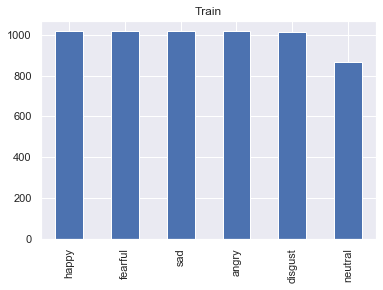

In [304]:
y_train_df = pd.DataFrame(data=y_train, columns=['label'])
y_train_df['label'].value_counts().plot.bar(title='Train')

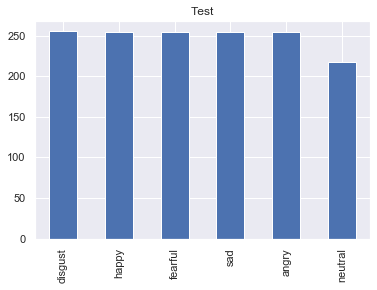

In [305]:
y_test_df = pd.DataFrame(data=y_test, columns=['label'])
y_test_df['label'].value_counts().plot.bar(title='Test')

In [306]:
# best model params, determined by a grid search
clf_params = {
    'alpha': 0.01,
    'batch_size': 256,
    'epsilon': 1e-08, 
    'hidden_layer_sizes': (300,), 
    'learning_rate': 'adaptive', 
    'max_iter': 500,
    'early_stopping': True,
    'validation_fraction':0.1,
    'verbose': 10,
    'n_iter_no_change': 10,
}

In [307]:
# init MLP classifier
clf = MLPClassifier(**clf_params)

In [308]:
# train the model
print("[*] Training the model...")
clf.fit(X_train, y_train)

[*] Training the model...
Iteration 1, loss = 1.76599243
Validation score: 0.328859
Iteration 2, loss = 1.68843508
Validation score: 0.365772
Iteration 3, loss = 1.62042010
Validation score: 0.360738
Iteration 4, loss = 1.57511428
Validation score: 0.372483
Iteration 5, loss = 1.55082644
Validation score: 0.369128
Iteration 6, loss = 1.53606882
Validation score: 0.367450
Iteration 7, loss = 1.52525627
Validation score: 0.370805
Iteration 8, loss = 1.51612780
Validation score: 0.355705
Iteration 9, loss = 1.51038141
Validation score: 0.372483
Iteration 10, loss = 1.50352742
Validation score: 0.377517
Iteration 11, loss = 1.49612865
Validation score: 0.390940
Iteration 12, loss = 1.49026019
Validation score: 0.369128
Iteration 13, loss = 1.48536922
Validation score: 0.375839
Iteration 14, loss = 1.47997400
Validation score: 0.377517
Iteration 15, loss = 1.47488846
Validation score: 0.379195
Iteration 16, loss = 1.47117318
Validation score: 0.380872
Iteration 17, loss = 1.46760415
Validat

MLPClassifier(activation='relu', alpha=0.01, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(300,), learning_rate='adaptive',
              learning_rate_init=0.001, max_iter=500, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=10, warm_start=False)

In [309]:
# classifier stats
print("Score/Accuracy:")
print(clf.score(X_test, y_test))

print("No. of layers:")
print(clf.n_layers_)

print("No. of epochs:")
print(clf.n_iter_)

print("Loss:")
print(clf.loss_)

print("Validation score:")
print(clf.validation_scores_[clf.n_iter_-1])

print("Out Activation:")
print(clf.out_activation_)

Score/Accuracy:
0.40026863666890533
No. of layers:
3
No. of epochs:
49
Loss:
1.3966887040036404
Validation score:
0.4278523489932886
Out Activation:
softmax


['neutral']
['angry' 'disgust' 'fearful' 'happy' 'neutral' 'sad']
[[0.10427132 0.17996075 0.18516107 0.16401548 0.27520917 0.09138221]]
['disgust']
['angry' 'disgust' 'fearful' 'happy' 'neutral' 'sad']
[[0.06015871 0.4110555  0.0757544  0.2486042  0.12764232 0.07678488]]
['neutral']
['angry' 'disgust' 'fearful' 'happy' 'neutral' 'sad']
[[0.11186312 0.1064162  0.09012311 0.18412179 0.43962468 0.0678511 ]]
['angry']
['angry' 'disgust' 'fearful' 'happy' 'neutral' 'sad']
[[0.42961274 0.094612   0.07391539 0.36946861 0.0296549  0.00273637]]


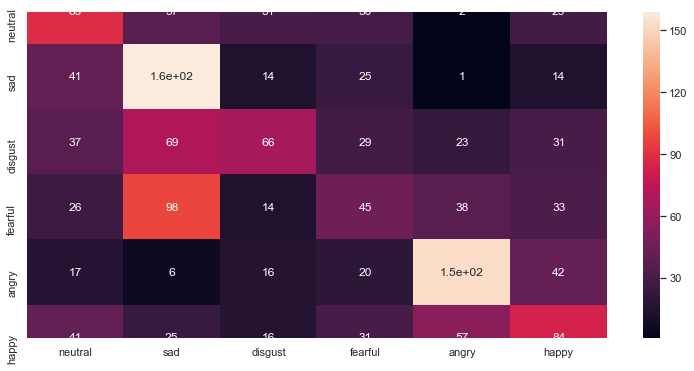

Accuracy: 40.03%


In [317]:
# clf predict
y_pred = clf.predict(X_test)
print(clf.predict(X_test[[1]]))
print(label_encoder.classes_)
print(clf.predict_proba(X_test[[1]]))

print(clf.predict(X_test[[30]]))
print(label_encoder.classes_)
print(clf.predict_proba(X_test[[30]]))

print(clf.predict(X_test[[22]]))
print(label_encoder.classes_)
print(clf.predict_proba(X_test[[22]]))

print(clf.predict(X_test[[1337]]))
print(label_encoder.classes_)
print(clf.predict_proba(X_test[[1337]]))

# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=list(AVAILABLE_EMOTIONS))
x_axis_labels = y_axis_labels = AVAILABLE_EMOTIONS

# plot cm dataframe
df_cm = pd.DataFrame(cm, range(6), range(6))
plt.figure(figsize=(13,6))
sn.set(font_scale=1) # for labels
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.show()

# calculate the accuracy
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

In [56]:
# save the model
# make result directory if doesn't exist yet
if not os.path.isdir("result"):
    os.mkdir("result")

pickle.dump(clf, open("result/mlp_classifier.model", "wb"))
pickle.dump(reg, open("result/reg.model", "wb"))

NameError: name 'model' is not defined